# TFIDF - NNMF analysis
- define what a document is
    - one uninterrupted speech made by speaker
    - all speeches made by speaker
    - all speeches made on the same date
- preprocess text
- count TFIDF
- do dimensionality reduciton/topic clustering with NNMF
- look for appropriate dimension with knee method
- try visualizing document-topic in 2D or 3D

Do this for both **euroleaks** and **communiques**, then do a comparative analysis if approapriate.

In [1]:
import re
import time

import numpy as np
import pandas as pd

# euroleaks

Get already cleaned data (see notebook clean.ipynb):

In [2]:
df = pd.read_csv('../data/euroleaks/cleaned.csv')
df.head()

,speaker,speech,timestamp,date
0,jeroen dijsselbloem,… of your responses or questions. and can i fi...,1900-01-01 00:00:00,2015-02-24 00:00:00
1,speaker 2,"uh, yes, uh, thank you, jeroen. well, uh, comm...",1900-01-01 00:00:10,2015-02-24 00:00:00
2,michael noonan,michael noonan.,1900-01-01 00:01:27,2015-02-24 00:00:00
3,speaker 2,"uh, it is therefore regrettable that, uh-",1900-01-01 00:01:29,2015-02-24 00:00:00
4,speaker 3,has entered the conference.,1900-01-01 00:01:33,2015-02-24 00:00:00


In [40]:
df_copy = df.copy()

## notes
- not sure whether to use token.lemma_ or f'{token.lemma_}_{token.pos_}'
    - POS allows for capital_ADJ and capital_NOUN to be differentiated
    - but also introduces noise because POS derivation is not always correct (e.g. capital_NOUN control_NOUN)

## stopwords
amend_names was constructed after exploratory analysis into names from the scraped data.

In [3]:
import json

with open('../data/euroleaks/amend_names.json', 'r') as f:
    amend_names = json.load(f)

In [4]:
# make stopwords out of names
stopnames = []

for names in amend_names.values():
    for name in names:
        if not re.search('\[.*\]', name):
            stopnames += name.split(' ')
            
for name in df.speaker.unique():
    if 'speaker' not in name:
        stopnames += name.split(' ')
    
stopnames = set(stopnames)

In [334]:
context_stopwords = [
    'erm', # synonym for hmm in https://euroleaks.diem25.org/leaks/mar17ewg/
]

## spacy

In [5]:
import spacy

nlp = spacy.load("en_core_web_sm", exclude=["ner"])

In [6]:
t = time.time()
doc = nlp(' '.join(df.speech)) # takes a few minutes
print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 1.51 mins


In [335]:
def token_filter(token):
    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
            and not token.is_stop\
            and not token.text in stopnames\
            and not token.text in context_stopwords\
            and len(token.text) > 1 # for punctuation (but also 'I')

## collocations

In [8]:
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

### trigrams

In [9]:
from nltk.collocations import TrigramCollocationFinder, TrigramAssocMeasures

# needs to be a one-dim list
# lemmatization, filter out punctuation and stop words
words = [token.lemma_ for sentence in doc.sents for token in sentence
            if token_filter(token)
        ]

finder = TrigramCollocationFinder.from_words(words)

# word might be highly correlated but very infrequent, ignore all with less than n occurances
finder.apply_freq_filter(5)

tgm = TrigramAssocMeasures()
collocations = {trigram: pmi for trigram, pmi in finder.score_ngrams(tgm.mi_like)}

In [10]:
collocations

{('euro', 'working', 'group'): 0.045454545454545456,
 ('comprehensive', 'valid', 'starting'): 0.027233115468409588,
 ('successful', 'conclusion', 'review'): 0.011784511784511785,
 ('low', 'interest', 'rate'): 0.010439612699499706,
 ('debt', 'sustainability', 'analysis'): 0.006432858214553638,
 ('valid', 'starting', 'point'): 0.006118453255017132,
 ('statement', '20th', 'february'): 0.005505095625703131,
 ('nominal', 'interest', 'rate'): 0.0030303030303030303,
 ('interest', 'rate', 'environment'): 0.0017536475869809204,
 ('list', 'prior', 'action'): 0.0015639581657280772,
 ('labor', 'market', 'reform'): 0.0015536554593193752,
 ('starting', 'point', 'successful'): 0.001529613313754283,
 ('staff', 'level', 'agreement'): 0.0012303485987696513,
 ('product', 'market', 'reform'): 0.0010193295077016006,
 ('set', 'prior', 'action'): 0.0009186602870813397,
 ('prior', 'action', 'list'): 0.00046339501206757845,
 ('discussion', 'brussel', 'group'): 0.0004310344827586207,
 ('low', 'low', 'pension'):

In [11]:
trigram_colloc = {('euro', 'working', 'group')}

### bigrams

In [12]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

finder = BigramCollocationFinder.from_words(words)

# word might be highly correlated but very infrequent, ignore all with less than n occurances
finder.apply_freq_filter(5)

bgm = BigramAssocMeasures()
collocations = {bigram: pmi for bigram, pmi in finder.score_ngrams(bgm.mi_like)}

In [13]:
threshold = 1

bigram_colloc_candidate = []
for bigram, score in collocations.items():
    if score > threshold:
        bigram_colloc_candidate.append(bigram)
    else:
        break
        
bigram_colloc_candidate = set(bigram_colloc_candidate)
bigram_colloc_candidate

{('20th', 'february'),
 ('aide', 'memoire'),
 ('anti', 'corruption'),
 ('brussel', 'group'),
 ('capital', 'control'),
 ('central', 'bank'),
 ('collective', 'bargaining'),
 ('common', 'ground'),
 ('debt', 'sustainability'),
 ('enter', 'conference'),
 ('euro', 'working'),
 ('govern', 'council'),
 ('growth', 'friendly'),
 ('half', 'percent'),
 ('interest', 'rate'),
 ('labor', 'market'),
 ('little', 'bit'),
 ('maximum', 'flexibility'),
 ('member', 'state'),
 ('minimum', 'wage'),
 ('primary', 'surplus'),
 ('prime', 'minister'),
 ('prior', 'action'),
 ('product', 'market'),
 ('second', 'letter'),
 ('smp', 'bond'),
 ('structural', 'reform'),
 ('successful', 'conclusion'),
 ('technical', 'team'),
 ('thank', 'thank'),
 ('valid', 'starting'),
 ('working', 'group')}

In [14]:
bigram_colloc = {
    ('20th', 'february'),
    ('aide', 'memoire'),
    ('anti', 'corruption'),
    ('brussel', 'group'),
    ('capital', 'control'),
    ('central', 'bank'),
    ('collective', 'bargaining'),
    ('common', 'ground'),
    ('debt', 'sustainability'),
    ('govern', 'council'),
    ('growth', 'friendly'),
    ('interest', 'rate'),
    ('labor', 'market'),
    ('maximum', 'flexibility'),
    ('member', 'state'),
    ('minimum', 'wage'),
    ('primary', 'surplus'),
    ('prime', 'minister'),
    ('prior', 'action'),
    ('product', 'market'),
    ('second', 'letter'),
    ('smp', 'bond'),
    ('structural', 'reform'),
    ('successful', 'conclusion'),
    ('technical', 'team'),
    ('real', 'estate')
}

In [15]:
# apply collocations
#df.speech = df.speech.apply(lambda s: apply_trigram_colloc(s, trigram_colloc))
#df.speech = df.speech.apply(lambda s: apply_bigram_colloc(s, bigram_colloc))

## document = one speech made by a speaker

In [17]:
# join speech of consecutive rows with same speaker

df_squeezed = pd.DataFrame(columns=['speaker','speech','date'])

previous_speaker = None
speech = None
previous_date = None

for index, data in df.iterrows():
    
    if not previous_speaker and not speech and not previous_date:
        previous_speaker = data.speaker
        speech = data.speech
        previous_date = data.date
    elif data.speaker == previous_speaker and previous_date == data.date:
        speech = ' '.join((speech, data.speech))
    else:
        df_squeezed.loc[len(df_squeezed.index)] = [
            previous_speaker,
            speech,
            previous_date
        ]
        previous_speaker = data.speaker
        speech = data.speech
        previous_date = data.date

In [24]:
documents = [
    ' '.join([token.lemma_ for sentence in nlp(doc).sents for token in sentence
              if token_filter(token)
             ])
             for doc in df_squeezed.speech.to_numpy()
]

In [25]:
# apply collocations
documents = pd.Series(documents).apply(lambda s: 
                apply_bigram_colloc(
                    apply_trigram_colloc(s, trigram_colloc),
                    bigram_colloc)
                                      )

In [28]:
print(f'There are {len(documents)} documents.')

There are 769 documents.


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=2,
                                   max_df=0.95,
                                   sublinear_tf=False)

X = tfidf_vectorizer.fit_transform(documents)                                  

In [30]:
idf = tfidf_vectorizer.idf_
tfidf = X.sum(axis =0).A1

In [31]:
# get tf
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer='word',
                                   min_df=2,
                                   max_df=0.95)

X_ = count_vectorizer.fit_transform(documents)

assert np.array_equal(
    count_vectorizer.get_feature_names(),
    tfidf_vectorizer.get_feature_names()
)

tf = X_.toarray().sum(axis=0)

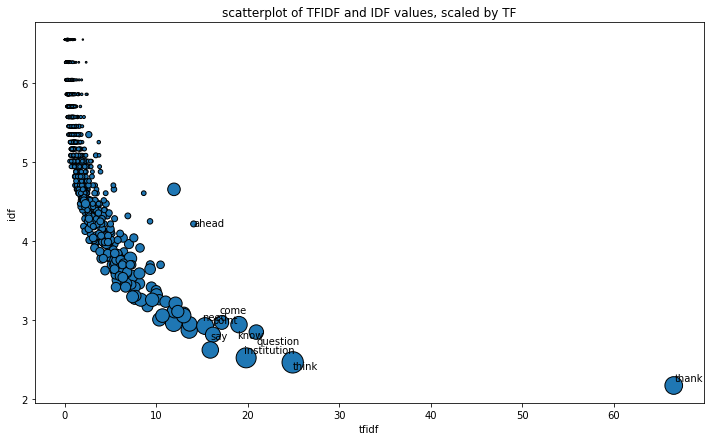

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(tfidf, idf, s=tf, edgecolors='black', label='tfidf')
#ax.legend()
ax.set_xlabel('tfidf')
ax.set_ylabel('idf')
ax.set_title('scatterplot of TFIDF and IDF values, scaled by TF')

# annotate words with highest tfidf
first_k = 10
sort_ix = np.argsort(tfidf)[::-1]
for ix in sort_ix[:first_k]:
    s = tfidf_vectorizer.get_feature_names()[ix]
    jiggle_x = np.random.normal(0,0.1)
    jiggle_y = np.random.normal(0,0.1)
    ax.text(tfidf[ix]+jiggle_x, idf[ix]+jiggle_y, s)

In [34]:
for word in np.array(tfidf_vectorizer.get_feature_names())[sort_ix][:10]:
    print(word)

thank
think
question
institution
know
come
point
say
need
ahead


In [35]:
X.shape

(769, 1918)

In [36]:
from sklearn.decomposition import NMF

reconstruction_error = []
for k in range(2, 50):
    
    nmf = NMF(n_components=k,
              init='nndsvd',
              beta_loss='frobenius',
              max_iter=400,
              random_state=0,
              alpha=0,
              l1_ratio=0)
    
    nmf.fit(X.toarray())
    
    reconstruction_error.append(nmf.reconstruction_err_)
    print(f'{k} - iterations: {nmf.n_iter_}')

2 - iterations: 8
3 - iterations: 8
4 - iterations: 8
5 - iterations: 13
6 - iterations: 16
7 - iterations: 19
8 - iterations: 20
9 - iterations: 57
10 - iterations: 116
11 - iterations: 31
12 - iterations: 104
13 - iterations: 155
14 - iterations: 105
15 - iterations: 110
16 - iterations: 324
17 - iterations: 114
18 - iterations: 99
19 - iterations: 124
20 - iterations: 222
21 - iterations: 104
22 - iterations: 93
23 - iterations: 143
24 - iterations: 148
25 - iterations: 81
26 - iterations: 116
27 - iterations: 75
28 - iterations: 88
29 - iterations: 216
30 - iterations: 371
31 - iterations: 95
32 - iterations: 84
33 - iterations: 89
34 - iterations: 216
35 - iterations: 92
36 - iterations: 114
37 - iterations: 84
38 - iterations: 138


/home/asajina/repos/master-thesis/.env/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


39 - iterations: 400
40 - iterations: 90
41 - iterations: 160


/home/asajina/repos/master-thesis/.env/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


42 - iterations: 400
43 - iterations: 279
44 - iterations: 106
45 - iterations: 204
46 - iterations: 163
47 - iterations: 271
48 - iterations: 204
49 - iterations: 142


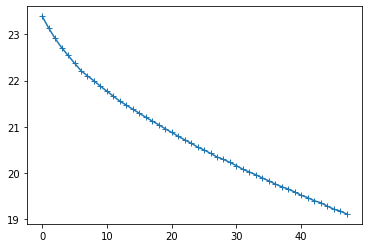

In [37]:
plt.plot(reconstruction_error, marker='+')

In [38]:
nmf = NMF(n_components=2,
          init='nndsvd',
          beta_loss='frobenius',
          max_iter=1000,
          random_state=0,
          alpha=0,
          l1_ratio=0)

W = nmf.fit_transform(X.toarray())
H = nmf.components_

print(f'W shape: {W.shape}')
print(f'H shape: {H.shape}')

W shape: (769, 2)
H shape: (2, 1918)


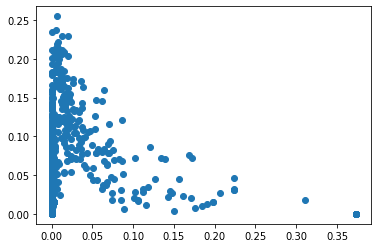

In [39]:
plt.scatter(W[:,0], W[:,1])

## document = speaker

In [176]:
df = df_copy.copy()

In [177]:
grouped = df.drop(columns=['timestamp','date']).groupby('speaker').apply(lambda s: ' '.join(s.speech))

In [178]:
grouped.head()

speaker
alexander stubb      thank you very much  foreign affairs council, ...
benoît cœuré         erm, yes thomas, good afternoon to all of you,...
christine lagarde    thank you very much, jerome and good afternoon...
computer             has entered the conference. has entered the co...
declan costello      yeah, thank you. erm, so just, just to add a b...
dtype: object

In [179]:
speakers = grouped.index

In [180]:
documents = [
    ' '.join([token.lemma_ for sentence in nlp(doc).sents for token in sentence
            if token_filter(token)
    ])
    for doc in grouped.values 
]

In [181]:
# apply collocations
documents = pd.Series(documents).apply(lambda s: 
                apply_bigram_colloc(
                    apply_trigram_colloc(s, trigram_colloc),
                    bigram_colloc)
                                      )

In [238]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=2, # word has to be in at least two documents
                                   max_df=0.95, # word has to be in less the 95% of documents
                                   smooth_idf=True, # Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.
                                   sublinear_tf=False) # replace tf with 1 + log(tf).

X = tfidf_vectorizer.fit_transform(documents)  

In [239]:
X.shape

(12, 1737)

In [60]:
from sklearn.decomposition import NMF

reconstruction_error = []
for k in range(2, 50):
    
    nmf = NMF(n_components=k,
              init='nndsvd',
              beta_loss='frobenius',
              max_iter=400,
              random_state=0,
              alpha=0,
              l1_ratio=0)
    
    nmf.fit(X.toarray())
    
    reconstruction_error.append(nmf.reconstruction_err_)
    print(f'{k} - iterations: {nmf.n_iter_}')

2 - iterations: 25
3 - iterations: 53
4 - iterations: 120
5 - iterations: 189
6 - iterations: 113
7 - iterations: 87
8 - iterations: 175


/home/asajina/repos/master-thesis/.env/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


9 - iterations: 400
10 - iterations: 191
11 - iterations: 263
12 - iterations: 185
13 - iterations: 331
14 - iterations: 347
15 - iterations: 308


/home/asajina/repos/master-thesis/.env/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


16 - iterations: 400
17 - iterations: 192


/home/asajina/repos/master-thesis/.env/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


18 - iterations: 400
19 - iterations: 160
20 - iterations: 264
21 - iterations: 174
22 - iterations: 182
23 - iterations: 126
24 - iterations: 157
25 - iterations: 285
26 - iterations: 149
27 - iterations: 278
28 - iterations: 359
29 - iterations: 278
30 - iterations: 65
31 - iterations: 104
32 - iterations: 273
33 - iterations: 205
34 - iterations: 178
35 - iterations: 180
36 - iterations: 191
37 - iterations: 253
38 - iterations: 248
39 - iterations: 66
40 - iterations: 270
41 - iterations: 130
42 - iterations: 61
43 - iterations: 130
44 - iterations: 293
45 - iterations: 345
46 - iterations: 77
47 - iterations: 342
48 - iterations: 126
49 - iterations: 141


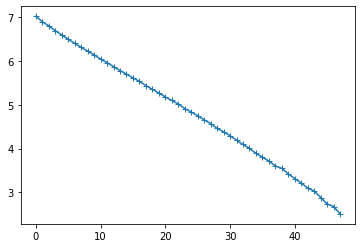

In [61]:
plt.plot(reconstruction_error, marker='+')

### 2D plot

In [183]:
nmf = NMF(n_components=2,
          init='nndsvd',
          beta_loss='frobenius',
          max_iter=1000,
          random_state=0,
          alpha=0,
          l1_ratio=0)

W = nmf.fit_transform(X.toarray())
H = nmf.components_

print(f'W shape: {W.shape}')
print(f'H shape: {H.shape}')

W shape: (62, 2)
H shape: (2, 1738)


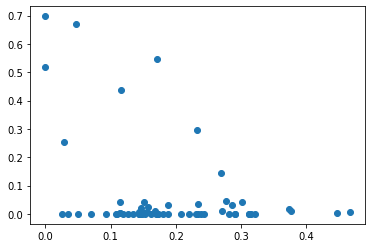

In [184]:
plt.scatter(W[:,0], W[:,1])

### 3D plot

In [185]:
nmf = NMF(n_components=3,
          init='nndsvd',
          beta_loss='frobenius',
          max_iter=1000,
          random_state=0,
          alpha=0,
          l1_ratio=0)

W = nmf.fit_transform(X.toarray())
H = nmf.components_

print(f'W shape: {W.shape}')
print(f'H shape: {H.shape}')

W shape: (62, 3)
H shape: (3, 1738)


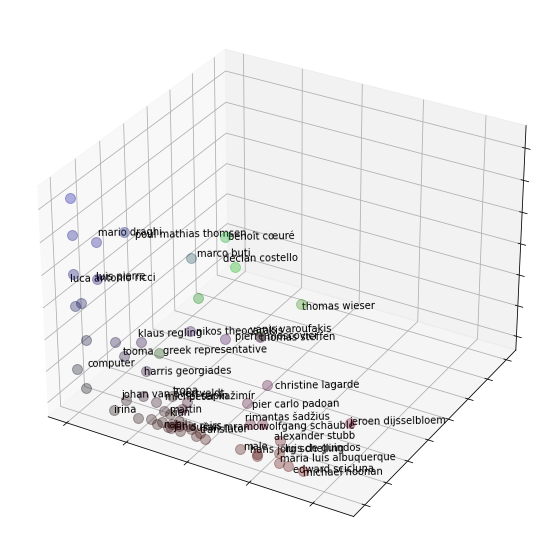

In [186]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# remove axis ticks
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

for point, label in zip(W, speakers):

    x,y,z = point
    ax.scatter( x, y, z,
                color=(x,y,z),
                edgecolor=None,
                alpha=0.3,
                s=100)
    
    jx, jy, jz = np.random.normal(0, 0.01, 3)
    
    if 'speaker' not in label:
        ax.text(x + jx,
                y + jy,
                z + jz,
                label,
                zdir=(1,1,0))

## _TODO_ document = entity

## document = date

In [336]:
df = df_copy.copy()

In [337]:
grouped = df.drop(columns=['timestamp','speaker']).groupby('date').apply(lambda s: ' '.join(s.speech))

In [338]:
grouped.head()

date
2015-02-24 00:00:00    … of your responses or questions. and can i fi...
2015-03-17 00:00:00    … coming in the next eh, in the next days and ...
2015-04-01 00:00:00    also uh have a discussion on the hfsf buffer a...
2015-04-24 00:00:00    uh, pierre, , welcome. thank you for joining u...
2015-05-11 00:00:00    … closely and they’re supposed to conclude the...
dtype: object

In [339]:
dates = grouped.index

In [340]:
documents = [
    ' '.join([token.lemma_ for sentence in nlp(doc).sents for token in sentence
            if token_filter(token)
    ])
    for doc in grouped.values 
]

In [341]:
# apply collocations
documents = pd.Series(documents).apply(lambda s: 
                apply_bigram_colloc(
                    apply_trigram_colloc(s, trigram_colloc),
                    bigram_colloc)
                                      )

In [342]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=1, # word has to be in at least two documents
                                   max_df=0.95, # word has to be in less the 95% of documents
                                   smooth_idf=True, # Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.
                                   sublinear_tf=False) # replace tf with 1 + log(tf).

X = tfidf_vectorizer.fit_transform(documents)  

In [343]:
X.shape

(12, 3332)

In [242]:
from sklearn.decomposition import NMF

reconstruction_error = []
for k in range(2, len(dates)+1):
    
    nmf = NMF(n_components=k,
              init='nndsvd',
              beta_loss='frobenius',
              max_iter=400,
              random_state=0,
              alpha=0,
              l1_ratio=0)
    
    nmf.fit(X.toarray())
    
    reconstruction_error.append(nmf.reconstruction_err_)
    print(f'{k} - iterations: {nmf.n_iter_}')

2 - iterations: 45
3 - iterations: 44
4 - iterations: 56
5 - iterations: 62
6 - iterations: 211
7 - iterations: 104
8 - iterations: 84
9 - iterations: 51
10 - iterations: 42
11 - iterations: 34
12 - iterations: 30


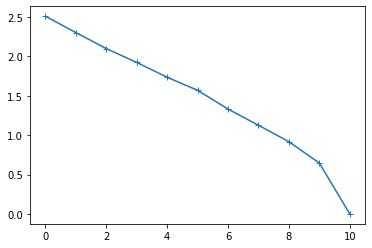

In [243]:
plt.plot(reconstruction_error, marker='+')

### 2D plot

In [344]:
nmf = NMF(n_components=2,
          init='nndsvd',
          beta_loss='frobenius',
          max_iter=1000,
          random_state=0,
          alpha=0,
          l1_ratio=0)

W = nmf.fit_transform(X.toarray())
H = nmf.components_

print(f'W shape: {W.shape}')
print(f'H shape: {H.shape}')

W shape: (12, 2)
H shape: (2, 3332)


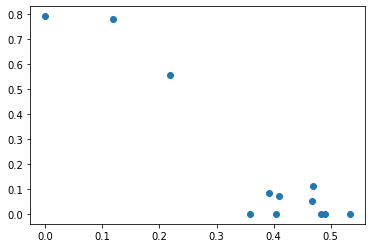

In [345]:
plt.scatter(W[:,0], W[:,1])

### 3D plot

In [346]:
nmf = NMF(n_components=3,
          init='nndsvd',
          beta_loss='frobenius',
          max_iter=1000,
          random_state=0,
          alpha=0,
          l1_ratio=0)

W = nmf.fit_transform(X.toarray())
H = nmf.components_

print(f'W shape: {W.shape}')
print(f'H shape: {H.shape}')

W shape: (12, 3)
H shape: (3, 3332)


In [347]:
# from: https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

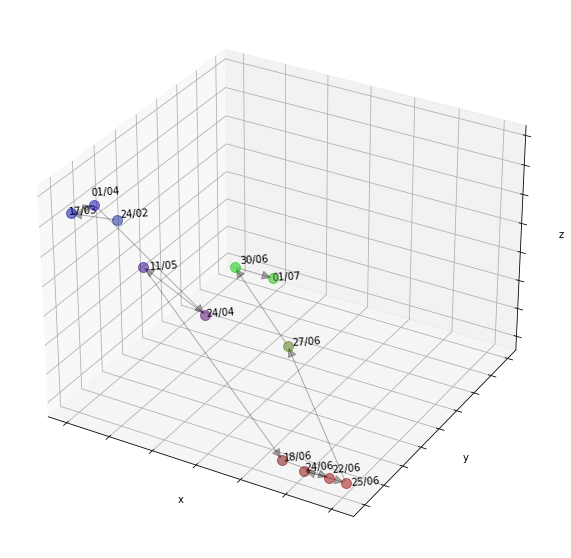

In [354]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# remove axis ticks
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for i, label in enumerate(dates):

    point = W[i,:]
    
    # plot
    x,y,z = point
    c = (min(max(x,0),1),min(max(y,0),1),min(max(z,0),1))
    ax.scatter( x, y, z,
                color=c,
                edgecolor=None,
                alpha=0.5,
                s=100)
    
    # annotate
    jx, jy, jz = np.random.normal(0, 0.01, 3)
    ax.text(x + jx,
            y + jy,
            z + jz,
            pd.to_datetime(label).strftime('%d/%m'),
            zdir=(1,1,0))
    
    # add arrow
    if i>0:
        previous_point = W[i-1,:]
        px, py, pz = previous_point
        #ax.arrow((px,x),(py,y),(pz,z),
        #        color='black',
        #        arrowstyle='-|>')
        #ax.quiver(px,py,pz,
        #          x,y,z,
        #          color='black',
        #          alpha=0.3,
        #          lw=2)
        arrow = Arrow3D([px,x],[py,y],[pz,z],
                        mutation_scale=20,
                        lw=1,
                        arrowstyle='-|>',
                        color='k',
                        alpha=0.3)
        ax.add_artist(arrow)

Cluster the data points by finding the base topic (the axis) with which the document has the largest projection value.

In [355]:
np.apply_along_axis(np.argmax,1,W)

array([2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1])

This kind of shows that the talks went "backwards" after announcement of greek referendum.

**TODO**
- [ ] keyword representation by topic
- [x] most prominent words by topic
- [ ] bring communiques into the picture

Get the most prominent words for every topic.

In [357]:
top_k = 50

pd.DataFrame({
    'red': np.array(tfidf_vectorizer.get_feature_names())[np.argsort(H[0,:])[::-1][:top_k]],
    'green': np.array(tfidf_vectorizer.get_feature_names())[np.argsort(H[1,:])[::-1][:top_k]],
    'blue': np.array(tfidf_vectorizer.get_feature_names())[np.argsort(H[2,:])[::-1][:top_k]]
})

,red,green,blue
0,agreement,letter,process
1,ask,referendum,list
2,document,second_letter,liquidity
3,program,program,reform
4,month,people,review
5,pension,change,progress
6,reform,political,athen
7,prior_action,request,agreement
8,interest_rate,new,week
9,aide_memoire,sla,policy


Get keyword representation by topic.

In [404]:
keywords = [
    # red
    'instit',
    'agreement',
    'interest_rate',
    'process',
    'reform',
    'program',
    'progress',
    'policy',
    'tax',
    'pension',
    'market',
    'parliament',
    'govern',
    # green
    'referendum',
    'letter',
    'second_letter',
    'people',
    'political',
    'change',
    'programme',
    'prime_minister',
    'eurogroup',
    'ecb',
    'imf',
    # blue
    'liquidity',
    'bank',
    'crisis',
    'mou',
    'debt',
    'aide_memoire',
    'technical',
    'bond',
    'esm',
    'brussel_group',
    'deficit'
]

keywords = np.sort(np.unique(keywords))

In [405]:
heatmap = pd.DataFrame(
    index = keywords,
    columns = ['red','green','blue'],
    data = [[H[i,:][tfidf_vectorizer.get_feature_names().index(word)] for i in range(3)] for word in keywords]
)

In [406]:
heatmap = heatmap[['blue','red','green']]

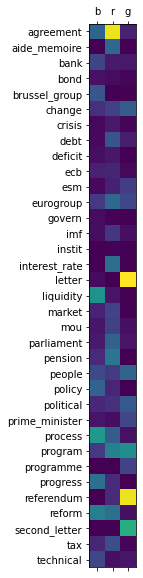

In [407]:
fig, ax = plt.subplots(figsize=(10,10))

ax.matshow(heatmap)
ax.set_yticks(range(heatmap.index.size))
_ = ax.set_yticklabels(heatmap.index)
ax.set_xticks(range(3))
_ = ax.set_xticklabels(['b','r','g'])

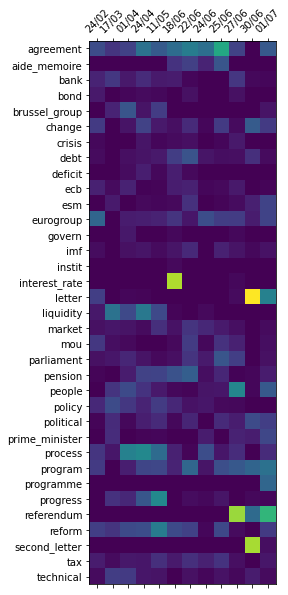

In [408]:
fig, ax = plt.subplots(figsize=(10,10))

ax.matshow(X.toarray()[:,[tfidf_vectorizer.get_feature_names().index(word) for word in keywords]].T)
ax.set_yticks(range(len(keywords)))
_ = ax.set_yticklabels(keywords)
ax.set_xticks(range(X.shape[0]))
formated_dates = dates.to_series().apply(lambda s: pd.to_datetime(s).strftime('%d/%m')).values
_ = ax.set_xticklabels(formated_dates, rotation=45)

In [409]:
for w in tfidf_vectorizer.get_feature_names():
    if w.startswith('instit'):
        print(w)

instit
institute
institutional
institutionalist
